In [ ]:
!pip install neptune
!pip install seaborn
!pip install torchmetrics
!pip install scikit-image
!pip install scikit-learn
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.9/487.9 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 140.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.3 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=37285302b8a68791fef904ee2325df3fd2518e94c7c7b87799eeb6c8077b017a
  Stored in directory: /root/.cache/pip/wheels/b8/56/c6/3695a1daf18ee45607f1d352fca288d173bc3b1722228c6fb1
Successfully built bravado-core
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import zipfile as zip
import numpy as np
import seaborn as sns
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms.v2 as T
from torchvision.datasets import ImageFolder
from torchvision import models
from sklearn.metrics import recall_score, precision_score, classification_report, confusion_matrix

In [ ]:
zip_path = '/content/drive/MyDrive/Diploma/Engineering/resnet/brain_tumor_dataset.zip'
extract_path = '/content/drive/MyDrive/Diploma/Engineering/resnet/brain_tumor_dataset'

with zip.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
def file_counter(root_folder):
    subfolder_img_count = {}

    for subfolder in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder)

        if os.path.isdir(subfolder_path):
            img_count = sum(1 for file in os.listdir(subfolder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg')))
            subfolder_img_count[subfolder] = img_count

    return subfolder_img_count

In [ ]:
train_folder = '/content/drive/MyDrive/Diploma/Engineering/resnet/brain_tumor_dataset/Training'
test_folder = '/content/drive/MyDrive/Diploma/Engineering/resnet/brain_tumor_dataset/Testing'

In [ ]:
training_data = file_counter(train_folder)
testing_data = file_counter(test_folder)

In [ ]:
print(training_data)
print(testing_data)

{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
{'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


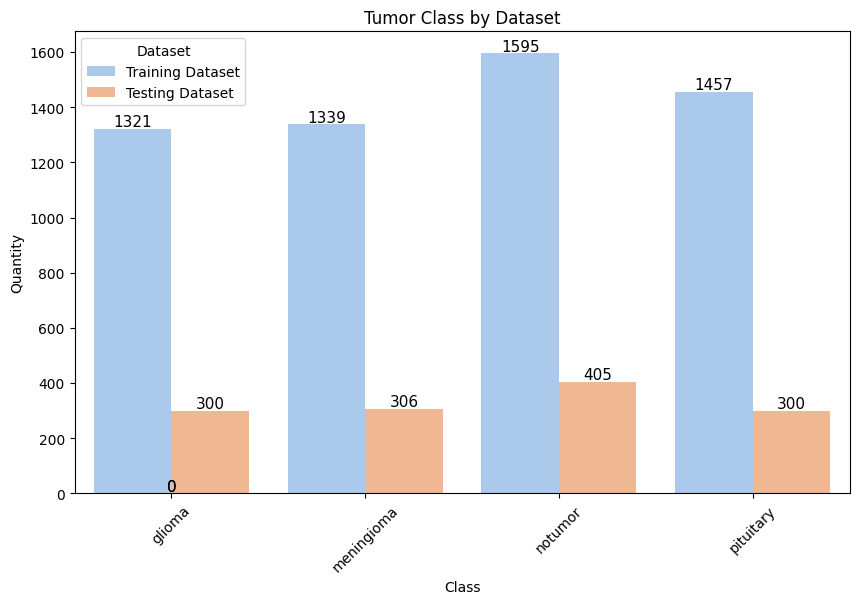

In [ ]:
df = pd.DataFrame({
    'Class': training_data.keys(),
    'Training Dataset' : training_data.values(),
    'Testing Dataset' : testing_data.values()
})

df_melted = df.melt(id_vars=['Class'],
                    value_vars=['Training Dataset', 'Testing Dataset'],
                    var_name='Dataset',
                    value_name='Quantity')

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melted, x='Class', y='Quantity', hue='Dataset', palette='pastel')

for i in ax.patches:
    ax.annotate(format(i.get_height(), '.0f'),
                (i.get_x() + i.get_width() / 2, i.get_height()),
                ha = 'center', va = 'center',
                size = 11, xytext = (0, 5),
                textcoords = 'offset points')

plt.title('Tumor Class by Dataset')
plt.xlabel('Class')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.show()

In [ ]:
def generating_sample_images(folder_path, num_images, name):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
    fig.suptitle(f"Sample {name} Images from Each Class", fontsize=16)

    class_folders = sorted(os.listdir(folder_path))
    for i, class_name in enumerate(class_folders):
        class_folder = os.path.join(folder_path, class_name)

        if not os.path.isdir(class_folder):
            continue

        image_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

        selected_files = random.sample(image_files, min(num_images, len(image_files)))

        for j, img_file in enumerate(selected_files):
            img_path = os.path.join(class_folder, img_file)
            img = mpimg.imread(img_path)

            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(class_name)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

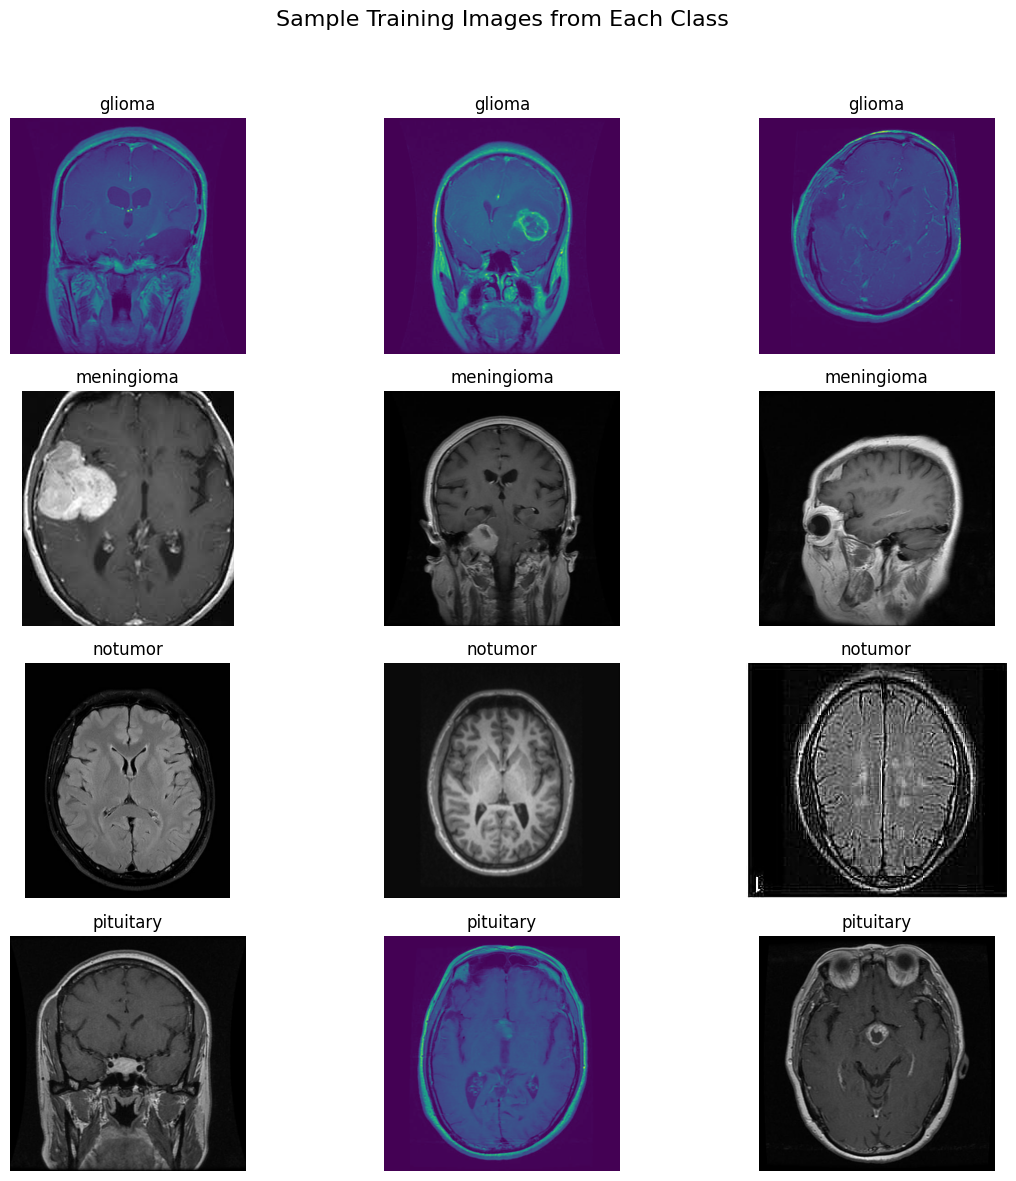

In [ ]:
generating_sample_images(train_folder, 3, 'Training')

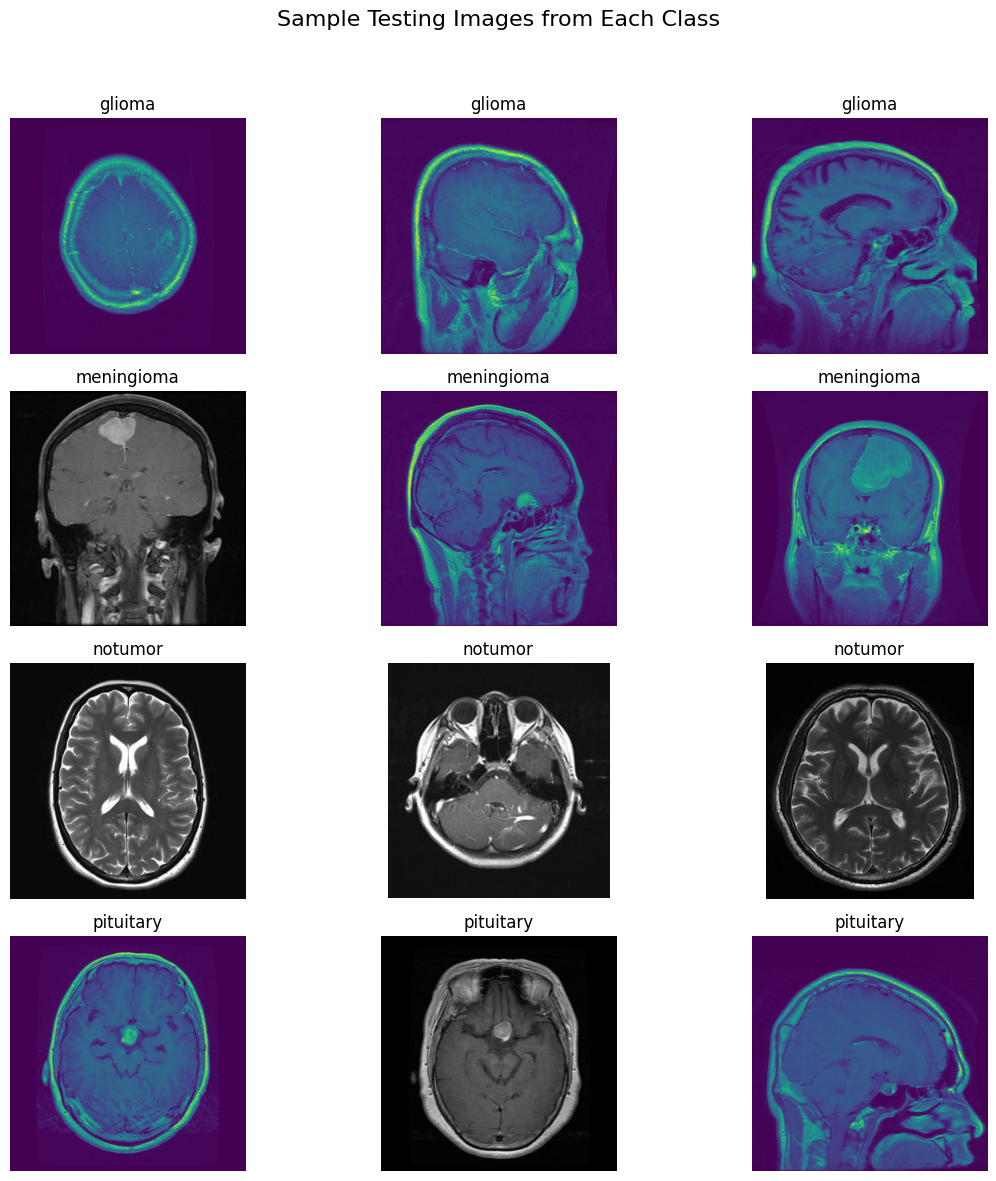

In [ ]:
generating_sample_images(test_folder, 3, 'Testing')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [ ]:
train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_data = ImageFolder(train_folder, transform=train_transforms)
test_data = ImageFolder(test_folder, transform=test_transforms)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-4

In [ ]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# ResNet50

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def m_f1_score(precision, recall):
    ## formula is (2 x precision x recall) / (precision + recall)

    f1 = 2 * precision * recall / (precision + recall)

    return f1

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_rec = recall_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')
    train_prec = precision_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')
    train_f1 = m_f1_score(train_prec, train_rec)

    print(f'[ === Epoch: {epoch+1}/{EPOCHS} === ]')
    print(f'Training Loss: {avg_loss:.6f}, Training Accuracy: {train_acc:.6f}, Training Recall: {train_rec:.6f}')
    print(f'Training Precision: {train_prec:.6f}, Training F1 Score: {train_f1:.6f}')



[ === Epoch: 1/20 === ]
Training Loss: 0.260295, Training Accuracy: 0.910014, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 2/20 === ]
Training Loss: 0.085796, Training Accuracy: 0.972514, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 3/20 === ]
Training Loss: 0.070335, Training Accuracy: 0.979167, Training Recall: 0.937500
Training Precision: 0.950000, Training F1 Score: 0.943709
[ === Epoch: 4/20 === ]
Training Loss: 0.050718, Training Accuracy: 0.981092, Training Recall: 0.950000
Training Precision: 0.937500, Training F1 Score: 0.943709
[ === Epoch: 5/20 === ]
Training Loss: 0.039008, Training Accuracy: 0.987045, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 6/20 === ]
Training Loss: 0.022390, Training Accuracy: 0.993697, Training Recall: 0.958333
Training Precision: 0.875000, Training F1 Score: 0.914773
[ === Epoch: 7/20 === ]
Trai

In [ ]:
classes = train_data.classes

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       300
           1       0.99      1.00      1.00       306
           2       1.00      1.00      1.00       405
           3       1.00      0.99      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



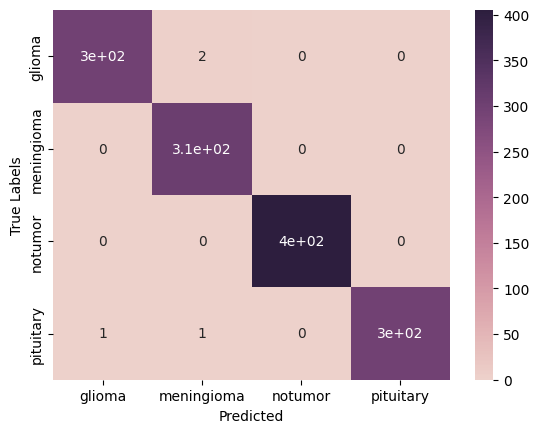

In [ ]:
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, cmap=sns.cubehelix_palette(as_cmap=True), annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True Labels')
plt.show()

In [ ]:
folder_path = '/content/drive/MyDrive/Diploma/Engineering/resnet/models/'

In [ ]:
model_name = 'Resnet50Model.pth'
torch.save(model.state_dict(), f'{folder_path}{model_name}')

# ResNet101

In [ ]:
model = models.resnet101(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:01<00:00, 122MB/s]


In [ ]:
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_rec = recall_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')
    train_prec = precision_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')
    train_f1 = m_f1_score(train_prec, train_rec)

    print(f'[ === Epoch: {epoch+1}/{EPOCHS} === ]')
    print(f'Training Loss: {avg_loss:.6f}, Training Accuracy: {train_acc:.6f}, Training Recall: {train_rec:.6f}')
    print(f'Training Precision: {train_prec:.6f}, Training F1 Score: {train_f1:.6f}')

[ === Epoch: 1/20 === ]
Training Loss: 0.221715, Training Accuracy: 0.920518, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 2/20 === ]
Training Loss: 0.085929, Training Accuracy: 0.971989, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 3/20 === ]
Training Loss: 0.066551, Training Accuracy: 0.977241, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 4/20 === ]
Training Loss: 0.059973, Training Accuracy: 0.981092, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[ === Epoch: 5/20 === ]
Training Loss: 0.057333, Training Accuracy: 0.983894, Training Recall: 0.604167
Training Precision: 0.700000, Training F1 Score: 0.648562
[ === Epoch: 6/20 === ]
Training Loss: 0.050856, Training Accuracy: 0.983718, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[ === Epoch: 7/20 === ]
Training Loss: 0.035605, Training Accuracy: 0.991246, Training Recall: 0.666667
Training Precision: 0.750000, Training F1 Score: 0.705882
[ === Epoch: 8/20 === ]
Training Loss: 0.044143, Training Accuracy: 0.984944, Training Recall: 0.968750
Training Precision: 0.916667, Training F1 Score: 0.941989
[ === Epoch: 9/20 === ]
Training Loss: 0.026803, Training Accuracy: 0.991947, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 10/20 === ]
Training Loss: 0.021202, Training Accuracy: 0.993347, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 11/20 === ]
Training Loss: 0.013987, Training Accuracy: 0.995273, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 12/20 === ]
Training Loss: 0.013601, Training Accuracy: 0.996849, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 13/20 === ]


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       300
           1       0.99      0.99      0.99       306
           2       1.00      1.00      1.00       405
           3       1.00      0.99      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



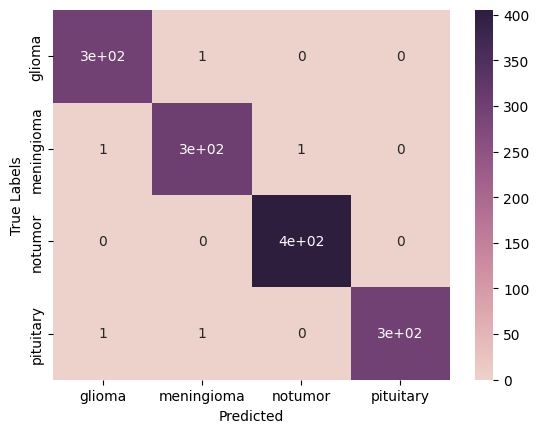

In [ ]:
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, cmap=sns.cubehelix_palette(as_cmap=True), annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True Labels')
plt.show()

In [ ]:
model_name = 'Resnet101Model.pth'
torch.save(model.state_dict(), f'{folder_path}{model_name}')

# ResNet152

In [ ]:
model = models.resnet152(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:02<00:00, 90.0MB/s]


In [ ]:
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_rec = recall_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')
    train_prec = precision_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')
    train_f1 = m_f1_score(train_prec, train_rec)

    print(f'[ === Epoch: {epoch+1}/{EPOCHS} === ]')
    print(f'Training Loss: {avg_loss:.6f}, Training Accuracy: {train_acc:.6f}, Training Recall: {train_rec:.6f}')
    print(f'Training Precision: {train_prec:.6f}, Training F1 Score: {train_f1:.6f}')

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[ === Epoch: 1/20 === ]
Training Loss: 0.235125, Training Accuracy: 0.919643, Training Recall: 0.664773
Training Precision: 0.750000, Training F1 Score: 0.704819
[ === Epoch: 2/20 === ]
Training Loss: 0.090281, Training Accuracy: 0.970763, Training Recall: 0.937500
Training Precision: 0.916667, Training F1 Score: 0.926966
[ === Epoch: 3/20 === ]
Training Loss: 0.066831, Training Accuracy: 0.977766, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 4/20 === ]
Training Loss: 0.045909, Training Accuracy: 0.984944, Training Recall: 0.968750
Training Precision: 0.937500, Training F1 Score: 0.952869
[ === Epoch: 5/20 === ]
Training Loss: 0.036332, Training Accuracy: 0.986520, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 6/20 === ]
Training Loss: 0.026549, Training Accuracy: 0.990371, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[ === Epoch: 7/20 === ]
Training Loss: 0.040289, Training Accuracy: 0.988095, Training Recall: 0.718750
Training Precision: 0.750000, Training F1 Score: 0.734043
[ === Epoch: 8/20 === ]
Training Loss: 0.044183, Training Accuracy: 0.984769, Training Recall: 0.964286
Training Precision: 0.916667, Training F1 Score: 0.939873
[ === Epoch: 9/20 === ]
Training Loss: 0.028471, Training Accuracy: 0.990896, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 10/20 === ]
Training Loss: 0.032611, Training Accuracy: 0.989671, Training Recall: 0.875000
Training Precision: 0.916667, Training F1 Score: 0.895349
[ === Epoch: 11/20 === ]
Training Loss: 0.020495, Training Accuracy: 0.993172, Training Recall: 0.958333
Training Precision: 0.950000, Training F1 Score: 0.954148
[ === Epoch: 12/20 === ]
Training Loss: 0.024434, Training Accuracy: 0.992647, Training Recall: 0.888889
Training Precision: 0.833333, Training F1 Score: 0.860215
[ === Epoch: 13/20 === ]


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       300
           1       0.99      1.00      1.00       306
           2       1.00      1.00      1.00       405
           3       1.00      1.00      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



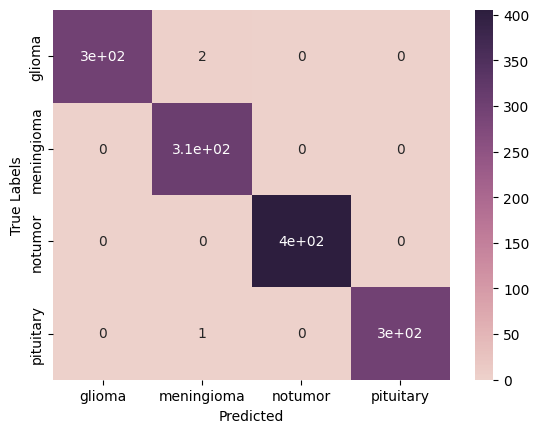

In [ ]:
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, cmap=sns.cubehelix_palette(as_cmap=True), annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True Labels')
plt.show()

In [ ]:
model_name = 'Resnet152Model.pth'
torch.save(model.state_dict(), f'{folder_path}{model_name}')

# VGG16


In [ ]:
model = models.vgg16_bn(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 4)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_rec = recall_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro', zero_division=0)
    train_prec = precision_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro', zero_division=0)
    train_f1 = m_f1_score(train_prec, train_rec)

    print(f'[ === Epoch: {epoch+1}/{EPOCHS} === ]')
    print(f'Training Loss: {avg_loss:.6f}, Training Accuracy: {train_acc:.6f}, Training Recall: {train_rec:.6f}')
    print(f'Training Precision: {train_prec:.6f}, Training F1 Score: {train_f1:.6f}')

[ === Epoch: 1/20 === ]
Training Loss: 0.454017, Training Accuracy: 0.825105, Training Recall: 0.916667
Training Precision: 0.958333, Training F1 Score: 0.937037
[ === Epoch: 2/20 === ]
Training Loss: 0.261938, Training Accuracy: 0.904237, Training Recall: 0.725000
Training Precision: 0.762500, Training F1 Score: 0.743277
[ === Epoch: 3/20 === ]
Training Loss: 0.219287, Training Accuracy: 0.918592, Training Recall: 0.906250
Training Precision: 0.875000, Training F1 Score: 0.890351
[ === Epoch: 4/20 === ]
Training Loss: 0.184511, Training Accuracy: 0.930322, Training Recall: 0.916667
Training Precision: 0.900000, Training F1 Score: 0.908257
[ === Epoch: 5/20 === ]
Training Loss: 0.169922, Training Accuracy: 0.933473, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 6/20 === ]
Training Loss: 0.158452, Training Accuracy: 0.942927, Training Recall: 0.954545
Training Precision: 0.750000, Training F1 Score: 0.840000
[ === Epoch: 7/20 === ]
Trai

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       300
           1       0.92      0.93      0.92       306
           2       0.98      1.00      0.99       405
           3       0.96      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



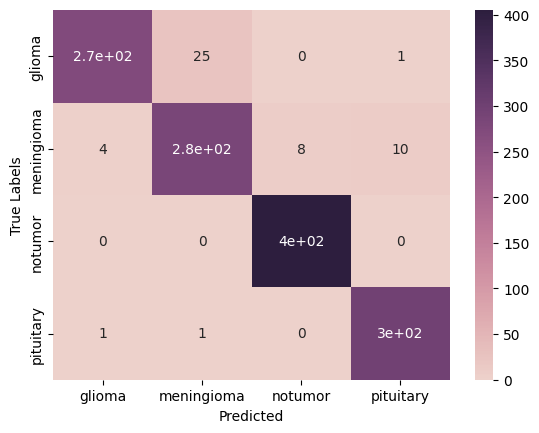

In [ ]:
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, cmap=sns.cubehelix_palette(as_cmap=True), annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True Labels')
plt.show()

In [ ]:
model_name = 'VGG16Model.pth'
torch.save(model.state_dict(), f'{folder_path}{model_name}')

# VGG19

In [ ]:
model = models.vgg19_bn(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 4)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


100%|██████████| 548M/548M [00:05<00:00, 105MB/s]


In [ ]:
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_rec = recall_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')
    train_prec = precision_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')
    train_f1 = m_f1_score(train_prec, train_rec)

    print(f'[ === Epoch: {epoch+1}/{EPOCHS} === ]')
    print(f'Training Loss: {avg_loss:.6f}, Training Accuracy: {train_acc:.6f}, Training Recall: {train_rec:.6f}')
    print(f'Training Precision: {train_prec:.6f}, Training F1 Score: {train_f1:.6f}')

[ === Epoch: 1/20 === ]
Training Loss: 0.488801, Training Accuracy: 0.819678, Training Recall: 0.866667
Training Precision: 0.866667, Training F1 Score: 0.866667
[ === Epoch: 2/20 === ]
Training Loss: 0.276011, Training Accuracy: 0.896709, Training Recall: 0.958333
Training Precision: 0.916667, Training F1 Score: 0.937037
[ === Epoch: 3/20 === ]
Training Loss: 0.220327, Training Accuracy: 0.919818, Training Recall: 0.875000
Training Precision: 0.854167, Training F1 Score: 0.864458
[ === Epoch: 4/20 === ]
Training Loss: 0.199025, Training Accuracy: 0.930672, Training Recall: 0.875000
Training Precision: 0.900000, Training F1 Score: 0.887324
[ === Epoch: 5/20 === ]
Training Loss: 0.181008, Training Accuracy: 0.932948, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 6/20 === ]
Training Loss: 0.153330, Training Accuracy: 0.943978, Training Recall: 0.937500
Training Precision: 0.916667, Training F1 Score: 0.926966
[ === Epoch: 7/20 === ]
Trai

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       300
           1       0.90      0.98      0.93       306
           2       1.00      1.00      1.00       405
           3       1.00      0.94      0.97       300

    accuracy                           0.97      1311
   macro avg       0.97      0.96      0.96      1311
weighted avg       0.97      0.97      0.97      1311



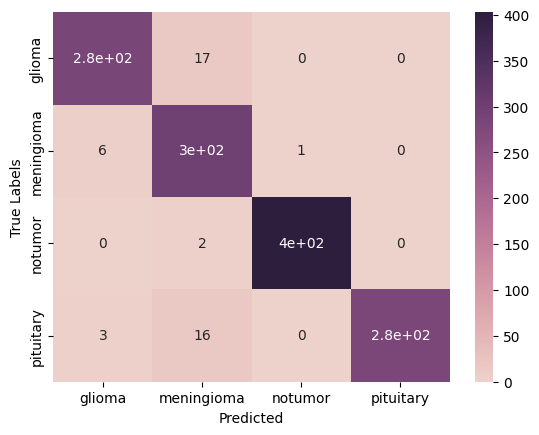

In [ ]:
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, cmap=sns.cubehelix_palette(as_cmap=True), annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True Labels')
plt.show()

In [ ]:
model_name = 'VGG19Model.pth'
torch.save(model.state_dict(), f'{folder_path}{model_name}')

# ResNet18

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


In [ ]:
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_rec = recall_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')
    train_prec = precision_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')
    train_f1 = m_f1_score(train_prec, train_rec)

    print(f'[ === Epoch: {epoch+1}/{EPOCHS} === ]')
    print(f'Training Loss: {avg_loss:.6f}, Training Accuracy: {train_acc:.6f}, Training Recall: {train_rec:.6f}')
    print(f'Training Precision: {train_prec:.6f}, Training F1 Score: {train_f1:.6f}')

[ === Epoch: 1/20 === ]
Training Loss: 0.297046, Training Accuracy: 0.892507, Training Recall: 0.825000
Training Precision: 0.804167, Training F1 Score: 0.814450


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[ === Epoch: 2/20 === ]
Training Loss: 0.106853, Training Accuracy: 0.964811, Training Recall: 0.500000
Training Precision: 0.750000, Training F1 Score: 0.600000
[ === Epoch: 3/20 === ]
Training Loss: 0.071516, Training Accuracy: 0.976541, Training Recall: 0.958333
Training Precision: 0.916667, Training F1 Score: 0.937037
[ === Epoch: 4/20 === ]
Training Loss: 0.054868, Training Accuracy: 0.983368, Training Recall: 0.937500
Training Precision: 0.875000, Training F1 Score: 0.905172
[ === Epoch: 5/20 === ]
Training Loss: 0.043254, Training Accuracy: 0.984594, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 6/20 === ]
Training Loss: 0.025234, Training Accuracy: 0.991947, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 7/20 === ]
Training Loss: 0.024301, Training Accuracy: 0.992997, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 8/20 === ]
Trai

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[ === Epoch: 14/20 === ]
Training Loss: 0.014027, Training Accuracy: 0.996849, Training Recall: 0.722222
Training Precision: 0.750000, Training F1 Score: 0.735849
[ === Epoch: 15/20 === ]
Training Loss: 0.020630, Training Accuracy: 0.994573, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 16/20 === ]
Training Loss: 0.010237, Training Accuracy: 0.997199, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 17/20 === ]
Training Loss: 0.012203, Training Accuracy: 0.996324, Training Recall: 0.958333
Training Precision: 0.875000, Training F1 Score: 0.914773
[ === Epoch: 18/20 === ]
Training Loss: 0.012364, Training Accuracy: 0.995973, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 19/20 === ]
Training Loss: 0.008465, Training Accuracy: 0.997549, Training Recall: 1.000000
Training Precision: 1.000000, Training F1 Score: 1.000000
[ === Epoch: 20/20 ===

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       300
           1       0.96      0.99      0.97       306
           2       0.99      1.00      1.00       405
           3       1.00      0.99      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



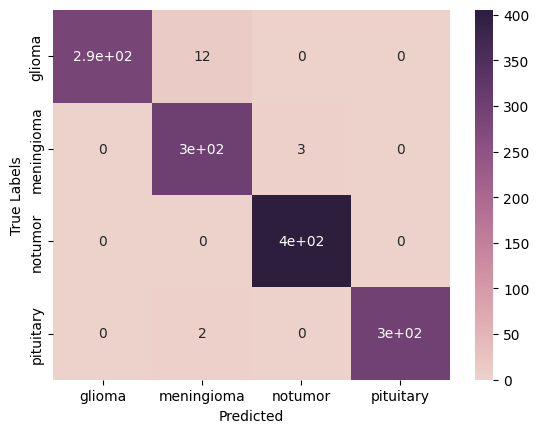

In [ ]:
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, cmap=sns.cubehelix_palette(as_cmap=True), annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True Labels')
plt.show()

In [ ]:
model_name = 'Resnet18Model.pth'
torch.save(model.state_dict(), f'{folder_path}{model_name}')